<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>
<img src="https://github.com/LinkedEarth/Logos/blob/master/LinkedEarth_medium.png?raw=true" width=500 alt="LinkedEarth Logo"></img>

# Investigating interhemispheric precipitation changes over the past millennium

---

## Overview

This Cookbook replicates some of the findings from [Steinman et al. (2022)](https://www.pnas.org/doi/full/10.1073/pnas.2120015119). Note that for demonstration purposes, this notebook only uses the median age for each proxy records rather than an ensemble. 

If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [81]:
#To deal with model data
import s3fs
import fsspec
import xarray as xr
import glob

#To deal with proxy data
import pandas as pd
import numpy as np

#To deal with analysis
import pyleoclim as pyleo
from eofs.xarray import Eof

#Plotting and mapping
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## PCA analysis on the CESM Last Millennium Analysis

The first step is the calculate precipitation $\delta^{18}O$ for the all forcing simulations. The following section demonstrates how to get the data from JetStream2 and pre-process each file to save the needed variable and place them into a new `xarray.Dataset`. This process can be time-consuming. 

### Get the data from JetStream2

Let's open the needed files for these calculations. All data have been made avialable on NSF JetStream2.


In [2]:
URL = 'https://js2.jetstream-cloud.org:8001/' #Locate and read a file

In [3]:
path = f'pythia/cesmLME' # specify data location

In [4]:
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL)) 
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))

Let's open relevant files for the all forcing simulations ('LME.002') for the 850-1850 period:

In [27]:
base_name = 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.'
time_period =  '085001-184912'

names = [name for name in files if base_name in name and time_period in name]

names

['pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H216Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H218Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H216OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H218OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H216Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H218Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H216OS.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H218OS.085001-184912.nc']

In [30]:
fileset = [fs.open(file) for file in names]

Next, let's open these datasets and extract the needed variables into another `xarray.Dataset`. 

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Note that this cell may take some time to run!
</div>

In [59]:
%%time
for idx,item in enumerate(fileset):
    ds_u = xr.open_dataset(item)
    var_name = names[idx].split('.')[-3]
    da = ds_u[var_name]
    try:
        ds[var_name]= da
    except:
        ds = da.to_dataset()
        ds.attrs = ds_u.attrs 
    ds_u.close()
    da.close()

CPU times: user 33.4 s, sys: 13.9 s, total: 47.3 s
Wall time: 6min 7s


In [60]:
ds

<xarray.Dataset> Size: 355MB
Dimensions:        (lat: 28, lon: 33, time: 12000)
Coordinates:
  * lat            (lat) float64 224B -25.58 -23.68 -21.79 ... 21.79 23.68 25.58
  * lon            (lon) float64 264B 250.0 252.5 255.0 ... 325.0 327.5 330.0
  * time           (time) object 96kB 0850-02-01 00:00:00 ... 1850-01-01 00:0...
Data variables:
    PRECRC_H218Or  (time, lat, lon) float32 44MB ...
    PRECRC_H216Or  (time, lat, lon) float32 44MB ...
    PRECRL_H216OR  (time, lat, lon) float32 44MB ...
    PRECRL_H218OR  (time, lat, lon) float32 44MB ...
    PRECSC_H216Os  (time, lat, lon) float32 44MB ...
    PRECSC_H218Os  (time, lat, lon) float32 44MB ...
    PRECSL_H216OS  (time, lat, lon) float32 44MB ...
    PRECSL_H218OS  (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.ie12.B1850C5CN.f19_g16.LME.002
    title:            UNSET
    logname:          tomas
    host:             r1i0n5
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850CN.f19_g16.850cntl.001.cam.i.0850-01-01-000...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/consisten...

### Select the American tropical region

Cut off to the correct geographical area to speed up calculations

In [74]:
ds_geo = ds.sel(lat=slice(-27,27), lon=slice(250,330))

Save this to file for later

In [67]:
#ds_geo.to_netcdf(path='../data/LME.002.cam.h0.precip_iso.085001-184912.nc')

In [75]:
ds_geo

<xarray.Dataset> Size: 355MB
Dimensions:        (lat: 28, lon: 33, time: 12000)
Coordinates:
  * lat            (lat) float64 224B -25.58 -23.68 -21.79 ... 21.79 23.68 25.58
  * lon            (lon) float64 264B 250.0 252.5 255.0 ... 325.0 327.5 330.0
  * time           (time) object 96kB 0850-02-01 00:00:00 ... 1850-01-01 00:0...
Data variables:
    PRECRC_H218Or  (time, lat, lon) float32 44MB ...
    PRECRC_H216Or  (time, lat, lon) float32 44MB ...
    PRECRL_H216OR  (time, lat, lon) float32 44MB ...
    PRECRL_H218OR  (time, lat, lon) float32 44MB ...
    PRECSC_H216Os  (time, lat, lon) float32 44MB ...
    PRECSC_H218Os  (time, lat, lon) float32 44MB ...
    PRECSL_H216OS  (time, lat, lon) float32 44MB ...
    PRECSL_H218OS  (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.ie12.B1850C5CN.f19_g16.LME.002
    title:            UNSET
    logname:          tomas
    host:             r1i0n5
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850CN.f19_g16.850cntl.001.cam.i.0850-01-01-000...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/consisten...

### Calculate Precipitation $\delta^{18}O$

In [76]:
%%time
p16O = ds_geo['PRECRC_H216Or'] + ds_geo['PRECSC_H216Os'] + ds_geo['PRECRL_H216OR'] + ds_geo['PRECSL_H216OS']
p18O = ds_geo['PRECRC_H218Or'] + ds_geo['PRECSC_H218Os'] + ds_geo['PRECRL_H218OR'] + ds_geo['PRECSL_H218OS']

p16O = p16O.where(p16O > 1e-18, 1e-18)
p18O = p18O.where(p18O > 1e-18, 1e-18)

d18Op = (p18O / p16O - 1)*1000

CPU times: user 48.1 s, sys: 11.8 s, total: 59.9 s
Wall time: 5min 57s


Calculate the anomalies

In [82]:
d18Oa = d18Op - d18Op.mean(dim='time')

Create an EOF solver to do the EOF analysis.

In [118]:
solver = Eof(d18Oa, weights=None)

Retrieve the leading EOF, expressed as the covariance between the leading PC time series and the input d18O anomalies at each grid point.

In [119]:
eof1 = solver.eofsAsCovariance(neofs=1)

Plot the leading EOF expressed covariance

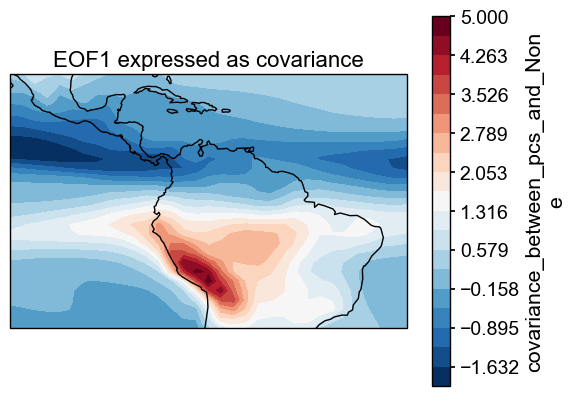

In [117]:
clevs = np.linspace(-2, 5, 20)
proj = ccrs.PlateCarree(central_longitude=290)
ax = plt.axes(projection=proj)
ax.coastlines()
#ax.set_global()
eof1[0].plot.contourf(ax=ax, levels = clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as covariance', fontsize=16)
plt.show()

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
new = "helpful information"

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!